# SOS Models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (12,10)
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.naive_bayes import MultinomialNB, CategoricalNB, ComplementNB, GaussianNB
from sklearn.metrics import roc_curve, auc
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

%xmode Minimal

Exception reporting mode: Minimal


###  Load Data

In [2]:
# load data 
sos = pd.read_csv('data/sos.csv')
sos_terms = pd.read_csv('data/df_custom_lemm.csv')

In [3]:
sos.head()
sos.shape
sos_terms.head()

,title,source,type_of_release,link,content,page_scraped,content_length,date_clean
0,Secretary Antony J. Blinken And Surinamese Pre...,Antony J. Blinken,Remarks,https://www.state.gov/secretary-antony-j-blink...,"SECRETARY BLINKEN: Well, good morning, everyon...",110.0,602,2022-09-15
1,"Targeting Russia’s Senior Officials, Defense I...",Antony J. Blinken,Press Statement,https://www.state.gov/targeting-senior-russian...,The United States continues to hold the Russia...,110.0,440,2022-09-15
2,Commemorating the International Day of Democracy,Antony J. Blinken,Press Statement,https://www.state.gov/commemorating-the-intern...,"This International Day of Democracy, we unders...",110.0,318,2022-09-15
3,Papua New Guinea National Day,Antony J. Blinken,Press Statement,https://www.state.gov/papua-new-guinea-nationa...,"On behalf of the United States of America, I e...",110.0,113,2022-09-15
4,El Salvador National Day,Antony J. Blinken,Press Statement,https://www.state.gov/el-salvador-national-day/,On behalf of the Government of the United Stat...,110.0,181,2022-09-15


(1973, 8)

,abandon,abandoned,abbas,abc,abducted,abdullah,abe,abhorrent,abide,abiding,...,zayed,zealand,zelenskyy,zelenskyy said,zero,zeya,zimbabwe,zone,zoom,zte
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
#simplify class for readability later on
sos['source_cl'] = np.where(sos.source == 'Antony J. Blinken', 'Blinken', 'Pompeo').copy()

In [5]:
#check this worked
sos.groupby('source').size()
sos.groupby('source_cl').size()

source
Antony J. Blinken    1019
Michael R. Pompeo     954
dtype: int64

source_cl
Blinken    1019
Pompeo      954
dtype: int64

### Set Up Definitions

In [6]:
# Fit model function 
def get_fit(model, xtrain, ytrain):
    '''input a model type and x and y training data
    fits the model'''
    new_model = model.fit(xtrain, ytrain)
    return new_model

In [7]:
# create definition to get fit and features 
def score_and_features(tree, xtrain, ytrain, xtest, ytest):
    new_tree = tree.fit(xtrain, ytrain)
    feature_df = pd.DataFrame({'Feature': xtest.columns, 'Importance': new_tree.feature_importances_})
    top_10 = feature_df.sort_values(by = 'Importance', ascending = False).head(10)
    return (round(new_tree.score(xtest, ytest),3), top_10)

In [8]:
# Scoring models function
def get_score(model, model_name, xtest, ytest):
    '''input a model type, model string name, data_name and x and y testing data
    prints the score '''
    result = model.score(xtest, ytest)
    return (f'{model_name}'+" score : " + str(round(result,3)))

### Train Test Split

In [9]:
x = sos_terms.copy()
y = sos.source_cl
set(y)

{'Blinken', 'Pompeo'}

In [10]:
# y = sos.source
# lb = LabelEncoder()
# lb.fit(y)
# lb.classes_
# y = lb.transform(y)

In [11]:
# train test, split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 42)

### Run Models

#### KNN 

In [12]:
# now let's train a model with the arbitrary k = 3
knn = KNeighborsClassifier(n_neighbors=3)

# fit
model_knn = get_fit(knn, x_train, y_train)

# score 
get_score(model_knn,'KNN', x_test, y_test)

'KNN score : 0.818'

In [13]:
# create a validation curve with default 5-fold cross-valduation 
neighbor_range = np.arange(1,11)

train_scores, test_scores = validation_curve(model_knn, x, y, param_name='n_neighbors',
                                            param_range=neighbor_range)

In [14]:
# find the mean of these scores
test_mean = np.mean(test_scores, axis=1)

Text(0.5, 0, 'Number of Neighbors')

Text(0, 0.5, 'Score')

Text(0.5, 1.0, 'KNN Validation Curve')

([<matplotlib.axis.XTick at 0x7f8f2c12afd0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

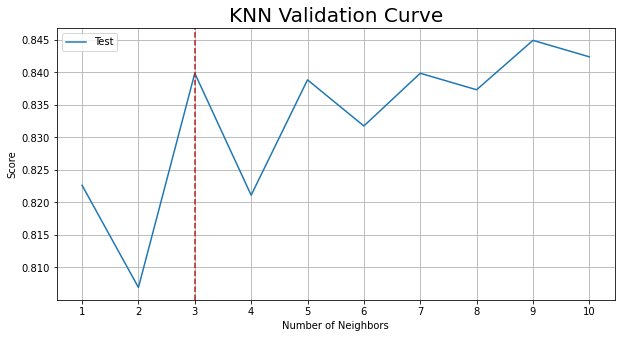

In [15]:
# plot this
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(neighbor_range, test_mean, label='Test')
plt.xlabel('Number of Neighbors')
plt.ylabel('Score')
plt.title('KNN Validation Curve', fontsize = 20)
plt.xticks(np.arange(1,11, step = 1))
plt.grid(True)
plt.legend()
plt.axvline(x=3, linestyle='dashed', color = 'firebrick')
plt.show()
# fig.savefig('knn_validation.png')

In [16]:
# 3 is arguably the best; 9 is better but increases complexity into the model so we'll keep 3

#### Decision Trees

In [17]:
tree = DecisionTreeClassifier(random_state=42)

In [18]:
score_and_features(tree, x_train, y_train, x_test, y_test)

(0.785,
               Feature  Importance
 14595         ukraine    0.186785
 2162          climate    0.109249
 724          american    0.091907
 11115          regime    0.028021
 2229        colleague    0.027997
 4612         everyone    0.022619
 1335   behalf america    0.021110
 1703            burma    0.013699
 2373        committed    0.013680
 5902         grateful    0.012464)

In [19]:
# create parameters
depth_range = np.arange(1,11)

train_scores_tree, test_scores_tree = validation_curve(tree, x, y, param_name ='max_depth', 
                                             param_range = depth_range, cv = 10)

# find means
train_mean_tree = np.mean(train_scores_tree, axis=1)
test_mean_tree = np.mean(test_scores_tree, axis=1)

([<matplotlib.axis.XTick at 0x7f8ee885a1c0>,
 [Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

Text(0.5, 0, 'Maximum Depth')

Text(0, 0.5, 'Score (R2)')

Text(0.5, 0.98, '  Decision Tree Validation Curve')

Text(0.5, 1.0, 'Maximum Depth')

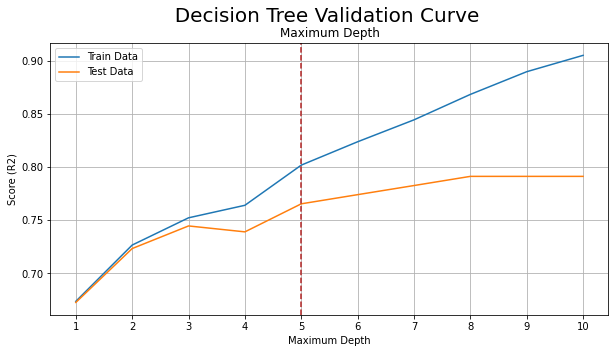

In [20]:
# plot
max_depth = np.arange(1,11)
fig1 = plt.figure(figsize = (10,5))
plt.plot(max_depth, train_mean_tree, label='Train Data')
plt.plot(max_depth, test_mean_tree, label='Test Data')
plt.grid(True)
plt.xticks(np.arange(1,11, step = 1))
plt.xlabel('Maximum Depth')
plt.ylabel('Score (R2)')
plt.suptitle('  Decision Tree Validation Curve', fontsize = 20)
plt.title('Maximum Depth')
plt.axvline(5, linestyle = 'dashed', color = 'firebrick')
plt.legend()
plt.show()

# fig1.savefig('dt_validation_curve_depth.png')

In [21]:
# create parameters
min_sample_range = np.arange(10,110,10)

train_scores_tree2, test_scores_tree2 = validation_curve(tree, x, y, param_name ='min_samples_split', 
                                             param_range = min_sample_range, cv = 10)

# find means
train_mean_tree2 = np.mean(train_scores_tree2, axis=1)
test_mean_tree2 = np.mean(test_scores_tree2, axis=1)

([<matplotlib.axis.XTick at 0x7f8f2aa48220>,
 [Text(10, 0, '10'),
  Text(20, 0, '20'),
  Text(30, 0, '30'),
  Text(40, 0, '40'),
  Text(50, 0, '50'),
  Text(60, 0, '60'),
  Text(70, 0, '70'),
  Text(80, 0, '80'),
  Text(90, 0, '90'),
  Text(100, 0, '100')])

Text(0.5, 0, 'Minimum Sample for Splitting')

Text(0, 0.5, 'Score (R2)')

Text(0.5, 0.98, ' Decision Tree Validation Curve')

Text(0.5, 1.0, 'Minimum Sample Size for Splitting')

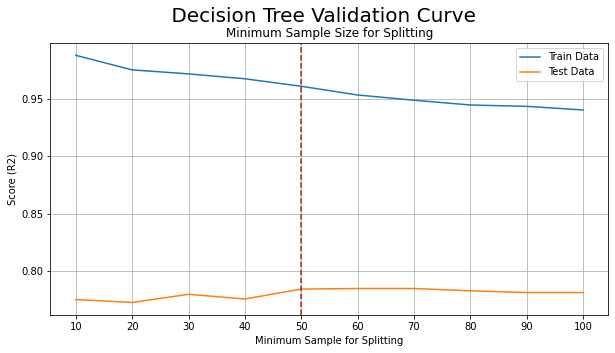

In [22]:
# plot
fig1 = plt.figure(figsize = (10,5))
plt.plot(min_sample_range, train_mean_tree2, label='Train Data')
plt.plot(min_sample_range, test_mean_tree2, label='Test Data')
plt.grid(True)
plt.xticks(np.arange(10,110, step = 10))
plt.xlabel('Minimum Sample for Splitting')
plt.ylabel('Score (R2)')
plt.suptitle(' Decision Tree Validation Curve', fontsize = 20)
plt.title('Minimum Sample Size for Splitting')
plt.axvline(50, linestyle = 'dashed', color = 'firebrick')
plt.legend()
plt.show()

# fig1.savefig('dt_validation_curve_minsamp.png')

In [23]:
# Let's do a maxdepth of 5 with min_Sample_range of 50 to maximize test score and keep relatively simple 
# (avoid overfitting)

tree_final = DecisionTreeClassifier(random_state=42, max_depth = 5, min_samples_split=50)

score_and_features(tree_final, x_train, y_train, x_test, y_test)

(0.744,
          Feature  Importance
 14595    ukraine    0.363060
 2162     climate    0.212351
 724     american    0.175356
 11115     regime    0.054465
 4612    everyone    0.043966
 2229   colleague    0.035878
 1703       burma    0.026628
 5902    grateful    0.024227
 6290   hizballah    0.018655
 1741        call    0.018207)

[Text(0.7083333333333334, 0.9166666666666666, 'ukraine <= 0.014\ngini = 0.5\nsamples = 1578\nvalue = [812, 766]\nclass = Pompeo'),
 Text(0.5119047619047619, 0.75, 'climate <= 0.02\ngini = 0.479\nsamples = 1223\nvalue = [487, 736]\nclass = Blinken'),
 Text(0.35714285714285715, 0.5833333333333334, 'american <= 0.013\ngini = 0.446\nsamples = 1100\nvalue = [369, 731]\nclass = Blinken'),
 Text(0.19047619047619047, 0.4166666666666667, 'regime <= 0.01\ngini = 0.498\nsamples = 640\nvalue = [300, 340]\nclass = Blinken'),
 Text(0.09523809523809523, 0.25, 'everyone <= 0.018\ngini = 0.498\nsamples = 513\nvalue = [274, 239]\nclass = Pompeo'),
 Text(0.047619047619047616, 0.08333333333333333, 'gini = 0.5\nsamples = 457\nvalue = [223, 234]\nclass = Blinken'),
 Text(0.14285714285714285, 0.08333333333333333, 'gini = 0.163\nsamples = 56\nvalue = [51, 5]\nclass = Pompeo'),
 Text(0.2857142857142857, 0.25, 'burma <= 0.075\ngini = 0.326\nsamples = 127\nvalue = [26, 101]\nclass = Blinken'),
 Text(0.2380952380

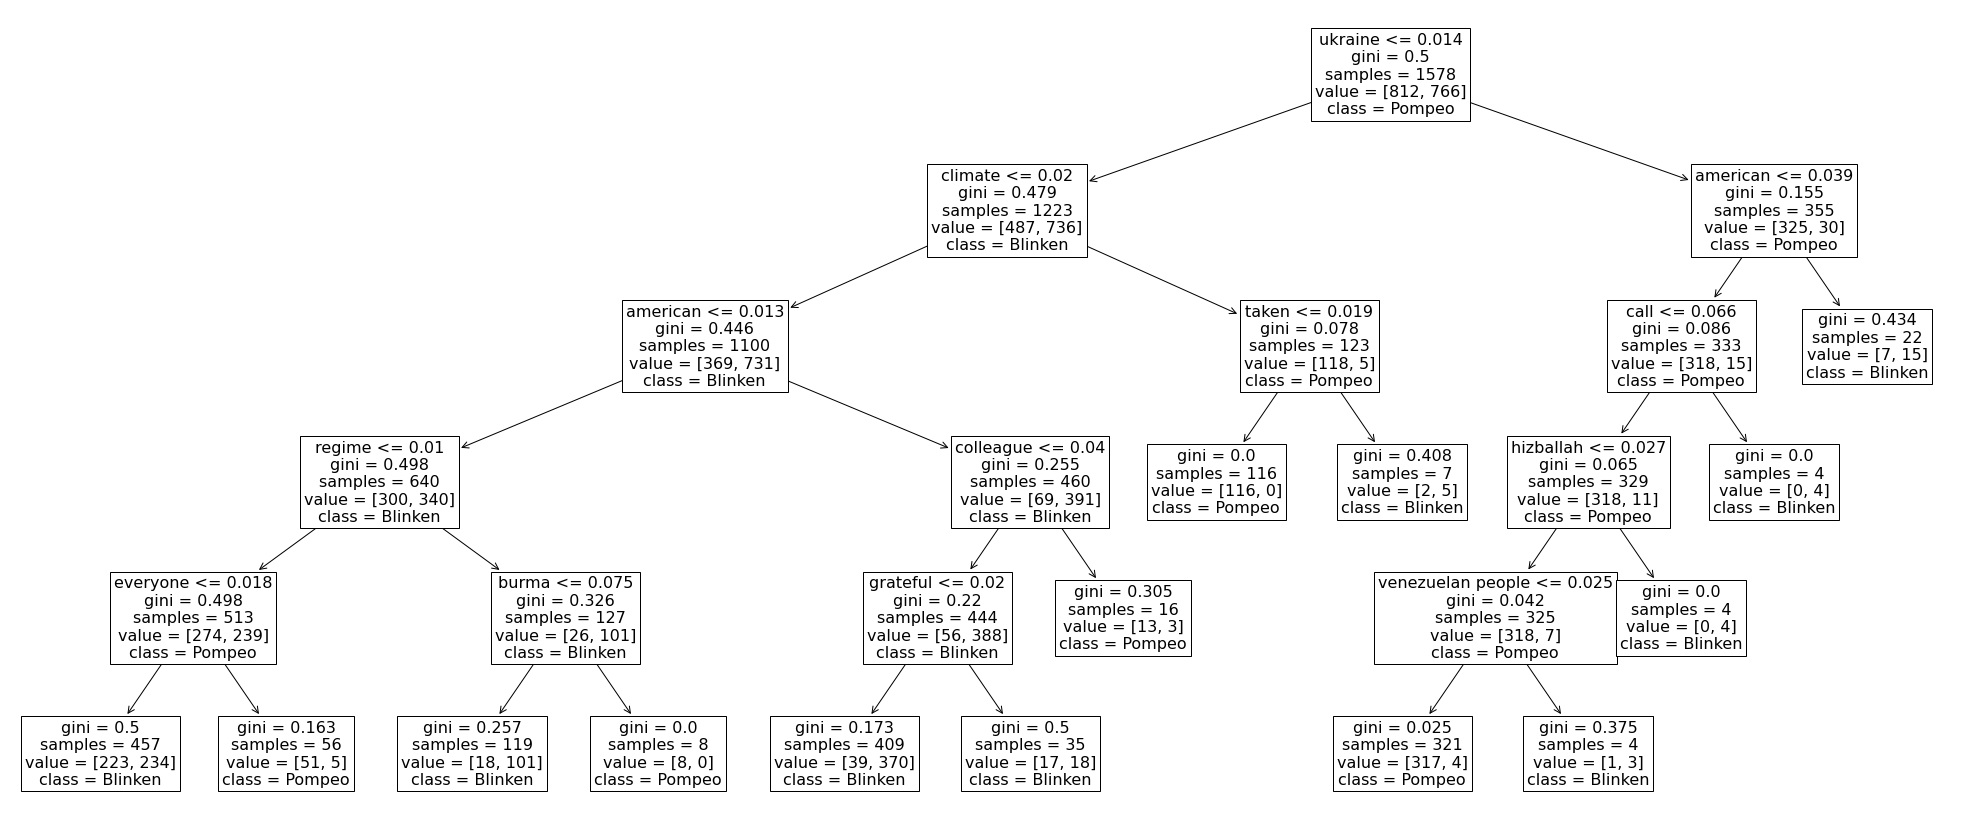

In [24]:
fig1 = plt.figure(figsize = (35, 15))
plot_tree(tree_final, feature_names = x_train.columns, class_names=list(set(y_test)), fontsize=16)
plt.show()
# fig1.savefig('dt.png')

In [25]:
dt_var_imp = pd.DataFrame({'Variable': x.columns, 
                        'Importance': tree_final.feature_importances_})
dt_var_imp_top = dt_var_imp[dt_var_imp.Importance > 0].copy()
dt_var_imp_sorted = dt_var_imp_top.sort_values(by='Importance', ascending = True).reset_index()
dt_var_imp_sorted

,index,Variable,Importance
0,14958,venezuelan people,0.010598
1,13504,taken,0.016609
2,1741,call,0.018207
3,6290,hizballah,0.018655
4,5902,grateful,0.024227
5,1703,burma,0.026628
6,2229,colleague,0.035878
7,4612,everyone,0.043966
8,11115,regime,0.054465
9,724,american,0.175356


<BarContainer object of 12 artists>

Text(0.5, 0, 'Proportion')

Text(0, 0.5, '')

Text(0.5, 1.0, 'Decision Tree')

Text(0.5, 0.98, 'Top Variables by Importance')

Text(0.27, 0, 'Mean R2 = 0.744')

Text(0.9, 0.01, 'From 1973* Secretary of State public remarks\n *1019 from Blinken in 2022\n *954 from Pompeo in 2020')

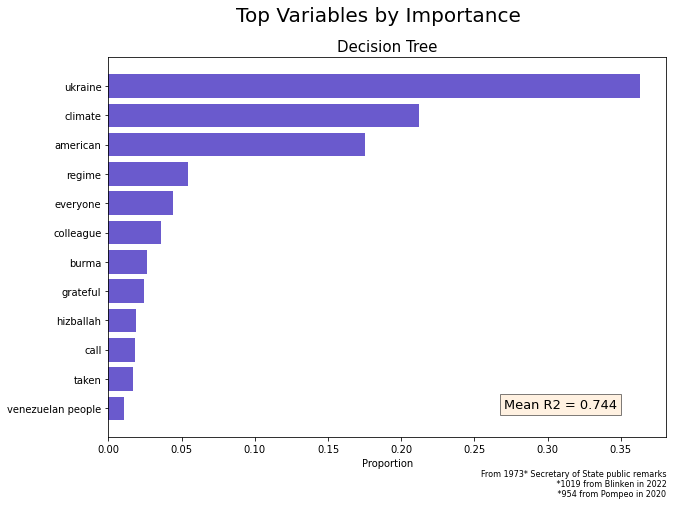

In [26]:
# plot 
fig1, ax = plt.subplots(figsize = (10,7))
plt.barh(dt_var_imp_sorted['Variable'], dt_var_imp_sorted['Importance'], color = 'slateblue')
plt.xlabel('Proportion')
plt.ylabel('')
plt.title('Decision Tree', fontsize = 15)
plt.suptitle('Top Variables by Importance',fontsize=20)
plt.text(0.27, 0, 'Mean R2 = 0.744', fontsize=13, bbox=dict(facecolor='bisque', alpha=0.5))
txt="From 1973* Secretary of State public remarks\n *1019 from Blinken in 2022\n *954 from Pompeo in 2020"
plt.figtext(0.9, 0.01, txt, wrap=True, horizontalalignment='right', fontsize=8)
plt.show()

# fig1.savefig('variable_imp_dt.png')

#### Random Forest 

In [27]:
rfmodel = RandomForestClassifier(n_estimators=750, random_state=42, max_depth = 5)
rfmodel.fit(x, y)

RandomForestClassifier(max_depth=5, n_estimators=750, random_state=42)

In [28]:
mean_score_rf = round(cross_val_score(rfmodel, x, y, cv=5).mean(),3)
mean_score_rf

0.837

In [29]:
rf_var_imp = pd.DataFrame({'Variable': x.columns, 
                        'Importance': rfmodel.feature_importances_})
rf_var_imp_sorted = rf_var_imp.sort_values(by='Importance', ascending = False).head(15)
rf_var_imp_sorted.reset_index(drop=True)
rf_var_imp_sorted = rf_var_imp_sorted.sort_values(by='Importance', ascending = True)

,Variable,Importance
0,communist party,0.018196
1,chinese,0.017223
2,climate,0.015852
3,ukraine,0.015691
4,communist,0.015271
5,american,0.014396
6,russia,0.013469
7,putin,0.012651
8,american people,0.010191
9,mike,0.010162


<BarContainer object of 15 artists>

Text(0.5, 0, 'Proportion')

Text(0, 0.5, '')

Text(0.5, 1.0, 'Random Forest')

Text(0.5, 0.98, '  Top 15 Variables by Importance')

Text(0.014, 0, 'Mean R2 = 0.837')

Text(0.9, 0.01, 'From 1973* Secretary of State public remarks\n *1019 from Blinken in 2022\n *954 from Pompeo in 2020')

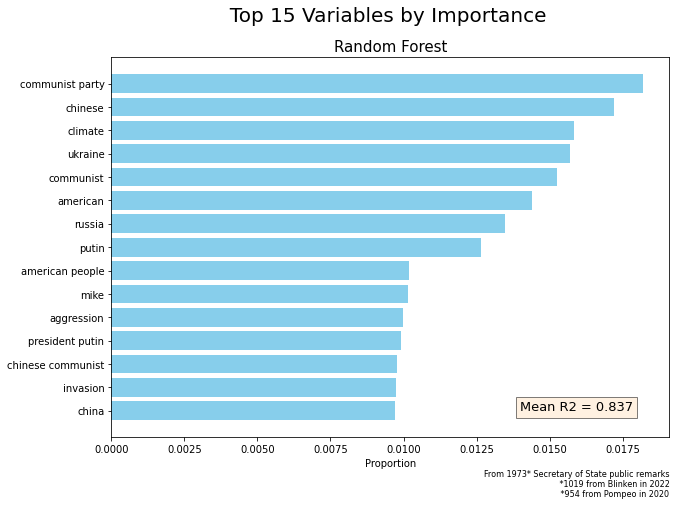

In [30]:
# plot 
fig1, ax = plt.subplots(figsize = (10,7))
plt.barh(rf_var_imp_sorted['Variable'], rf_var_imp_sorted['Importance'], color = 'skyblue')
plt.xlabel('Proportion')
plt.ylabel('')
plt.title('Random Forest', fontsize = 15)
plt.suptitle('  Top 15 Variables by Importance',fontsize=20)
plt.text(0.014, 0, 'Mean R2 = 0.837', fontsize=13, bbox=dict(facecolor='bisque', alpha=0.5))
txt="From 1973* Secretary of State public remarks\n *1019 from Blinken in 2022\n *954 from Pompeo in 2020"
plt.figtext(0.9, 0.01, txt, wrap=True, horizontalalignment='right', fontsize=8)
plt.show()

# fig1.savefig('variable_imp_rf.png')

#### Naive Bayes

In [31]:
mnb = MultinomialNB()

# fit model
modelMNB = mnb.fit(x_train, y_train)

# cross-validation 
MNB_cv = cross_val_score(modelMNB, x_test, y_test, cv=5)

# compute mean test accuracy
MNB_mean = np.mean(MNB_cv)
print("Mean multinomial naive bayes accuracy score with 5-fold cross-validation: " + str(round(MNB_mean, 4)))

Mean multinomial naive bayes accuracy score with 5-fold cross-validation: 0.8152


#### PCA 

In [32]:
# generate principle components
pca = PCA()
pca.fit(x)
pca.explained_variance_ratio_

PCA()

array([2.32478300e-02, 1.39659918e-02, 9.31643607e-03, ...,
       1.54591491e-34, 2.06149391e-35, 1.61220744e-35])

In [33]:
len(pca.explained_variance_ratio_)

1973

In [34]:
pc_variance = list(pca.explained_variance_ratio_)
pc_variance_top5 = sum(pc_variance[:5])
print('First 5 PC explain '+ str(round(pc_variance_top5, 4)) + 
      ' of variance in full dataset')

First 5 PC explain 0.06 of variance in full dataset


In [35]:
factor_loadings = pca.components_  #extract the component loadings
matrix = np.transpose(factor_loadings) #flip the rows and cols 
fl = pd.DataFrame(data = matrix, index = x.columns)
top_5 = fl.iloc[:,0:5]
top_5.columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
top_5.head()

,PC1,PC2,PC3,PC4,PC5
abandon,0.000776,0.001482,0.000505,0.002350,-0.001162
abandoned,0.001184,0.001393,-0.001943,0.001211,-0.002089
abbas,0.001300,0.001918,-0.000782,0.000675,0.002421
abc,0.001818,-0.000835,0.001114,-0.000594,0.000470
abducted,-0.000689,0.003055,-0.002373,-0.002782,-0.004142


In [36]:
PC1_20 = top_5.sort_values(by = 'PC1', ascending = False).head(20)
PC2_20 = top_5.sort_values(by = 'PC2', ascending = False).head(20)
PC3_20 = top_5.sort_values(by = 'PC3', ascending = False).head(20)
PC4_20 = top_5.sort_values(by = 'PC4', ascending = False).head(20)
PC5_20 = top_5.sort_values(by = 'PC5', ascending = False).head(20)

In [37]:
PC1_20_terms = list(PC1_20.index)
# PC1_20_terms
# talking terms

PC2_20_terms = list(PC2_20.index)
# PC2_20_terms
# sanctions and iran

PC3_20_terms = list(PC3_20.index)
# PC3_20_terms
# ukraine and russia

PC4_20_terms = list(PC4_20.index)
# PC4_20_terms
# ukrain and russia again 

PC5_20_terms = list(PC5_20.index)
# PC5_20_terms
# designations?

<Figure size 720x360 with 0 Axes>

Text(0.5, 0, 'Components')

Text(0, 0.5, 'PVE')

(0.0, 0.1)

Text(0.5, 1.0, 'Proportion of Variance Explained')

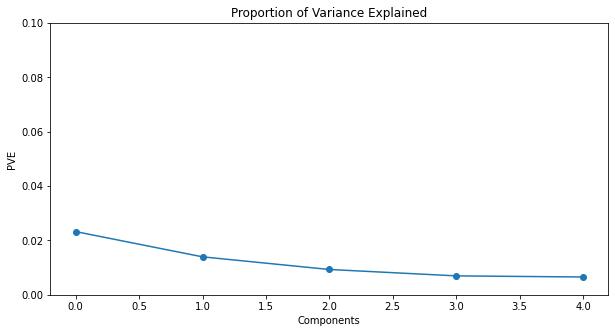

In [38]:
plt.figure(figsize=(10,5))
plt.plot(pca.explained_variance_ratio_[0:5],marker = 'o')
plt.xlabel("Components")
plt.ylabel("PVE")
plt.ylim(0,0.1)
#plt.xticks(np.arange(5),('PC1','PC2','PC3', 'PC4','PC5'))
plt.title("Proportion of Variance Explained")
plt.show()

#### Blinken PCA

In [41]:
blinken = pd.read_csv('data/df_blinken_lemm.csv')

In [42]:
# blinken.head()

In [43]:
pca.fit(blinken)
pca.explained_variance_ratio_
len(pca.explained_variance_ratio_)

PCA()

array([2.81623202e-02, 1.83660355e-02, 1.23144089e-02, ...,
       1.15124370e-34, 4.29121691e-35, 2.19487168e-35])

1019

In [44]:
pc_variance_blinken = list(pca.explained_variance_ratio_)
pc_variance_blinken_top5 = sum(pc_variance_blinken[:5])
print('First 5 PC explain '+ str(round(pc_variance_blinken_top5, 4)) + 
      ' of variance in Blinken dataset')

First 5 PC explain 0.079 of variance in Blinken dataset


In [45]:
factor_loadings_blinken = pca.components_  #extract the component loadings
matrix_blinken = np.transpose(factor_loadings_blinken) #flip the rows and cols 
fl_blinken = pd.DataFrame(data = matrix_blinken, index = blinken.columns)
top_5_blinken = fl_blinken.iloc[:,0:5]
top_5_blinken.columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
top_5_blinken.head()

,PC1,PC2,PC3,PC4,PC5
abc,0.002349,-0.000683,0.000148,-0.002036,-0.000737
abe,0.002215,-0.003933,-0.002370,0.019173,0.001324
abide,-0.000472,0.002516,-0.003077,-0.002780,0.006208
abiding,0.000169,-0.000418,-0.002030,-0.003316,0.002758
ability,0.020181,0.012903,-0.007278,-0.018563,-0.021841


In [46]:
PC1_20_blinken = top_5_blinken.sort_values(by = 'PC1', ascending = False).head(20)
PC2_20_blinken = top_5_blinken.sort_values(by = 'PC2', ascending = False).head(20)
PC3_20_blinken = top_5_blinken.sort_values(by = 'PC3', ascending = False).head(20)
PC4_20_blinken = top_5_blinken.sort_values(by = 'PC4', ascending = False).head(20)
PC5_20_blinken = top_5_blinken.sort_values(by = 'PC5', ascending = False).head(20)

In [47]:
PC1_20_blinken_terms = list(PC1_20_blinken.index)
# PC1_20_blinken_terms
# interview terms, could be cut out more in the future 

PC2_20_blinken_terms = list(PC2_20_blinken.index)
# PC2_20_blinken_terms
# sanctions, russia, ukraine 

PC3_20_blinken_terms = list(PC3_20_blinken.index)
# PC3_20_blinken_terms
# military assistance for ukraine and russia

PC4_20_blinken_terms = list(PC4_20_blinken.index)
# PC4_20_blinken_terms
# diplomatic niceties 

PC5_20_blinken_terms = list(PC5_20_blinken.index)
PC5_20_blinken_terms
# military assistance

['assistance',
 'drawdown',
 'million',
 'humanitarian',
 'community',
 'billion',
 'arm equipment',
 'pursuant delegation',
 'billion since',
 'military assistance',
 'department defense',
 'total',
 'since',
 'humanitarian assistance',
 'authorizing',
 'arm',
 'bring total',
 'violence',
 'world',
 'equipment department']

<Figure size 720x360 with 0 Axes>

Text(0.5, 0, 'Components')

Text(0, 0.5, 'PVE')

(0.0, 0.1)

([<matplotlib.axis.XTick at 0x7f8f2ffcea90>,
 [Text(0, 0, 'PC1'),
  Text(1, 0, 'PC2'),
  Text(2, 0, 'PC3'),
  Text(3, 0, 'PC4'),
  Text(4, 0, 'PC5')])

Text(0.5, 1.0, 'Proportion of Variance Explained - Blinken')

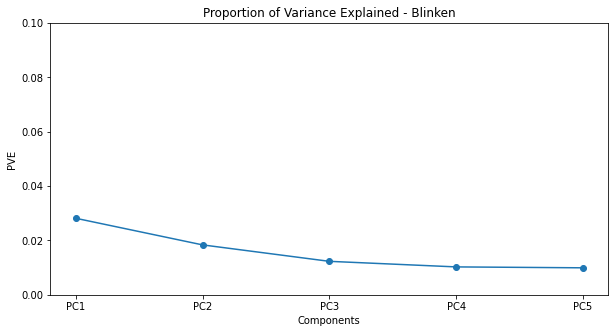

In [48]:
plt.figure(figsize=(10,5))
plt.plot(pca.explained_variance_ratio_[0:5],marker = 'o')
plt.xlabel("Components")
plt.ylabel("PVE")
plt.ylim(0,0.1)
plt.xticks(np.arange(5),('PC1','PC2','PC3', 'PC4','PC5'))
plt.title("Proportion of Variance Explained - Blinken")
plt.show()

#### Pompeo PCA

In [51]:
pompeo = pd.read_csv('data/df_pompeo_lemm.csv')

In [52]:
# pompeo.head()

In [53]:
pca.fit(pompeo)
pca.explained_variance_ratio_
len(pca.explained_variance_ratio_)

PCA()

array([3.52847833e-02, 2.01901063e-02, 9.72620822e-03, 9.52592043e-03,
       8.70146737e-03, 8.17466297e-03, 8.02279476e-03, 7.49792624e-03,
       7.00130176e-03, 6.19579908e-03, 5.64333637e-03, 5.12418234e-03,
       4.89583748e-03, 4.70616600e-03, 4.52246453e-03, 4.46083251e-03,
       4.29955522e-03, 4.11621948e-03, 3.97897659e-03, 3.96871015e-03,
       3.76713080e-03, 3.71774027e-03, 3.61537748e-03, 3.53917983e-03,
       3.52699842e-03, 3.43125338e-03, 3.36277145e-03, 3.25041595e-03,
       3.18800267e-03, 3.17401382e-03, 3.08963871e-03, 3.05338986e-03,
       3.04184478e-03, 3.01463037e-03, 2.94188173e-03, 2.86508557e-03,
       2.84339883e-03, 2.78760299e-03, 2.75359403e-03, 2.71415281e-03,
       2.68301683e-03, 2.66670545e-03, 2.65655263e-03, 2.60320103e-03,
       2.57888063e-03, 2.56919481e-03, 2.54468690e-03, 2.52520696e-03,
       2.51134863e-03, 2.48481929e-03, 2.43418609e-03, 2.41386772e-03,
       2.39169734e-03, 2.38375756e-03, 2.35811410e-03, 2.34649882e-03,
      

954

In [54]:
pc_variance_pompeo = list(pca.explained_variance_ratio_)
pc_variance_pompeo_top5 = sum(pc_variance_pompeo[:5])
print('First 5 PC explain '+ str(round(pc_variance_pompeo_top5, 4)) + 
      ' of variance in Pompeo dataset')

First 5 PC explain 0.0834 of variance in Pompeo dataset


In [55]:
# create factor loading matrix
factor_loadings_pompeo = pca.components_  #extract the component loadings
matrix_pompeo = np.transpose(factor_loadings_pompeo) #flip the rows and cols 
fl_pompeo = pd.DataFrame(data = matrix_pompeo, index = pompeo.columns)
top_5_pompeo = fl_pompeo.iloc[:,0:5]
top_5_pompeo.columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5']
top_5_pompeo.head()

,PC1,PC2,PC3,PC4,PC5
abandoned,0.001721,0.001271,-0.001735,-0.002046,-0.003405
abdullah,0.001712,0.000560,-0.012453,-0.008764,-0.004013
abide,0.001322,0.004253,0.009583,-0.009368,0.002025
ability,0.011790,0.014316,-0.009829,-0.009367,-0.009362
able,0.033205,-0.007626,-0.008533,-0.000729,0.007143


In [56]:
PC1_20_pompeo = top_5_pompeo.sort_values(by = 'PC1', ascending = False).head(20)
PC2_20_pompeo = top_5_pompeo.sort_values(by = 'PC2', ascending = False).head(20)
PC3_20_pompeo = top_5_pompeo.sort_values(by = 'PC3', ascending = False).head(20)
PC4_20_pompeo = top_5_pompeo.sort_values(by = 'PC4', ascending = False).head(20)
PC5_20_pompeo = top_5_pompeo.sort_values(by = 'PC5', ascending = False).head(20)

In [57]:
PC1_20_pompeo_terms = list(PC1_20_pompeo.index)
# PC1_20_pompeo_terms
# not very descriptive; seems to be interview terms?

PC2_20_pompeo_terms = list(PC2_20_pompeo.index)
# PC2_20_pompeo_terms
# sanctions related 

PC3_20_pompeo_terms = list(PC3_20_pompeo.index)
# PC3_20_pompeo_terms
# China 

PC4_20_pompeo_terms = list(PC4_20_pompeo.index)
# PC4_20_pompeo_terms
# corruption, narcotics, organized crime, etc. 

PC5_20_pompeo_terms = list(PC5_20_pompeo.index)
PC5_20_pompeo_terms
# very similar to pc4, but includes humanitarian and venezuala

['million',
 'reward',
 'narcotic',
 'assistance',
 'transnational',
 'humanitarian',
 'bureau',
 'reward program',
 'transnational organized',
 'organized crime',
 'venezuelan',
 'humanitarian assistance',
 'drug',
 'organized',
 'information leading',
 'enforcement',
 'refugee',
 'law enforcement',
 'health',
 'donor']

<Figure size 720x360 with 0 Axes>

Text(0.5, 0, 'Components')

Text(0, 0.5, 'PVE')

(0.0, 0.1)

([<matplotlib.axis.XTick at 0x7f8f2ebdf670>,
 [Text(0, 0, 'PC1'),
  Text(1, 0, 'PC2'),
  Text(2, 0, 'PC3'),
  Text(3, 0, 'PC4'),
  Text(4, 0, 'PC5')])

Text(0.5, 1.0, 'Proportion of Variance Explained - Pompeo')

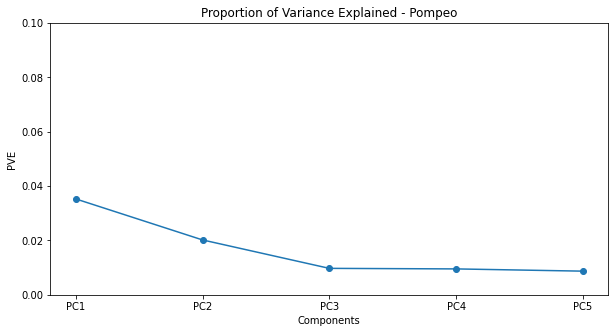

In [58]:
plt.figure(figsize=(10,5))
plt.plot(pca.explained_variance_ratio_[0:5],marker = 'o')
plt.xlabel("Components")
plt.ylabel("PVE")
plt.ylim(0,0.1)
plt.xticks(np.arange(5),('PC1','PC2','PC3', 'PC4','PC5'))
plt.title("Proportion of Variance Explained - Pompeo")
plt.show()